In [ ]:
!pip install pytree

In [1]:
import jax
from jax import numpy as jnp
from pytreeclass import treeclass,tree_viz
import matplotlib.pyplot as plt

@treeclass
class Linear :
   # Any variable not wrapped with @treeclass
   # should be declared as a dataclass field here
   weight : jnp.ndarray
   bias   : jnp.ndarray

   def __init__(self,key,in_dim,out_dim):
       self.weight = jax.random.normal(key,shape=(in_dim, out_dim)) * jnp.sqrt(2/in_dim)
       self.bias = jnp.ones((1,out_dim))

   def __call__(self,x):
       return x @ self.weight + self.bias

@treeclass
class StackedLinear:

    def __init__(self,key,in_dim,out_dim,hidden_dim):
        keys= jax.random.split(key,3)

        # Declaring l1,l2,l3 as dataclass_fields is optional
        # as they are already wrapped with @treeclass
        self.l1 = Linear(key=keys[0],in_dim=in_dim,out_dim=hidden_dim)
        self.l2 = Linear(key=keys[1],in_dim=hidden_dim,out_dim=hidden_dim)
        self.l3 = Linear(key=keys[2],in_dim=hidden_dim,out_dim=out_dim)

    def __call__(self,x):
        x = self.l1(x)
        x = jax.nn.tanh(x)
        x = self.l2(x)
        x = jax.nn.tanh(x)
        x = self.l3(x)

        return x

model = StackedLinear(in_dim=1,out_dim=1,hidden_dim=10,key=jax.random.PRNGKey(0))

x = jnp.linspace(0,1,100)[:,None]
y = x**3 + jax.random.uniform(jax.random.PRNGKey(0),(100,1))*0.01

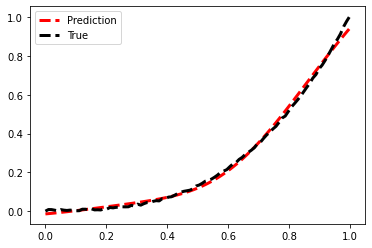

In [16]:
 
x = jnp.linspace(0,1,100)[:,None]
y = x**3 + jax.random.uniform(jax.random.PRNGKey(0),(100,1))*0.01

def loss_func(model,x,y):
    return jnp.mean((model(x)-y)**2 )

@jax.jit
def update(model,x,y):
    value,grads = jax.value_and_grad(loss_func)(model,x,y)
    # no need to use `jax.tree_map` to update the model
    # as it model is wrapped by @treeclass
    return value , model-1e-3*grads

for _ in range(1,20_001):
    value,model = update(model,x,y)

plt.plot(x,model(x),'--r',label = 'Prediction',linewidth=3)
plt.plot(x,y,'--k',label='True',linewidth=3)
plt.legend()


In [2]:
# freeze l1
model.l1 = model.l1.freeze()

# set non-negative values in l2 to 0
model.l2 = model.l2.at[model.l2<0].set(0)

# frozen nodes are marked with #
print(tree_viz.tree_diagram(model))

StackedLinear
    ├── l1=Linear
    │   ├#─ weight=f32[1,10]
    │   └#─ bias=f32[1,10]  
    ├── l2=Linear
    │   ├── weight=f32[10,10]
    │   └── bias=f32[1,10]  
    └── l3=Linear
        ├── weight=f32[10,1]
        └── bias=f32[1,1]       
